# 1. Importation des libs

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder


from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


## 2. Chargement de données

In [118]:
data = pd.read_csv("Data/MoMTSim_20240722202413_1000_dataset.csv")

## 3. Exploration des Données

In [119]:
data.head()

,step,transactionType,amount,initiator,oldBalInitiator,newBalInitiator,recipient,oldBalRecipient,newBalRecipient,isFraud
0,0,PAYMENT,579.16,4018807983755588,29.32,29.32,30-0000345,0.00,0.00,0
1,0,TRANSFER,39.03,4610593854752035,39.03,0.00,4944921135715488,55.94,94.98,1
2,0,TRANSFER,21.78,4840578447365454,21.78,0.00,4305579785620656,58.09,79.88,1
3,0,PAYMENT,570.22,4958066799829630,5.29,5.29,00-0000388,0.00,0.00,0
4,0,PAYMENT,574.80,4149196095918843,82.63,82.63,80-0005320,0.00,0.00,0


In [120]:
data.columns

Index(['step', 'transactionType', 'amount', 'initiator', 'oldBalInitiator',
       'newBalInitiator', 'recipient', 'oldBalRecipient', 'newBalRecipient',
       'isFraud'],
      dtype='object')

In [121]:
# Reconversion de la colonne initiator en type string (object)
data['initiator'] = data['initiator'].astype(str)

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225958 entries, 0 to 4225957
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   step             int64  
 1   transactionType  object 
 2   amount           float64
 3   initiator        object 
 4   oldBalInitiator  float64
 5   newBalInitiator  float64
 6   recipient        object 
 7   oldBalRecipient  float64
 8   newBalRecipient  float64
 9   isFraud          int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 322.4+ MB


In [123]:
data.describe()

,step,amount,oldBalInitiator,newBalInitiator,oldBalRecipient,newBalRecipient,isFraud
count,4.225958e+06,4.225958e+06,4.225958e+06,4.225958e+06,4.225958e+06,4.225958e+06,4.225958e+06
mean,9.811771e+01,5.302139e+04,2.246055e+07,2.246527e+07,1.685005e+06,1.703967e+06,5.284288e-01
std,5.573710e+01,2.708194e+06,6.418504e+07,6.421561e+07,6.795783e+06,6.802160e+06,4.991912e-01
min,0.000000e+00,0.000000e+00,-1.999926e+05,-1.999926e+05,-7.477966e+04,0.000000e+00,0.000000e+00
25%,5.000000e+01,9.444000e+01,4.681000e+01,0.000000e+00,3.345156e+04,4.251237e+04,0.000000e+00
50%,9.900000e+01,5.966900e+02,3.655435e+03,0.000000e+00,2.007614e+05,2.042479e+05,1.000000e+00
75%,1.470000e+02,1.708469e+04,2.344082e+05,8.150306e+04,2.002134e+06,2.041814e+06,1.000000e+00
max,1.920000e+02,7.654805e+08,6.409231e+08,6.409231e+08,3.810134e+08,3.813883e+08,1.000000e+00


In [124]:
data.isnull().sum()

step               0
transactionType    0
amount             0
initiator          0
oldBalInitiator    0
newBalInitiator    0
recipient          0
oldBalRecipient    0
newBalRecipient    0
isFraud            0
dtype: int64

In [125]:
# Vérifier les valeurs uniques dans chaque colonne
for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")


step: 193 unique values
transactionType: 5 unique values
amount: 603069 unique values
initiator: 1653981 unique values
oldBalInitiator: 1984015 unique values
newBalInitiator: 1453570 unique values
recipient: 22517 unique values
oldBalRecipient: 2589983 unique values
newBalRecipient: 2649159 unique values
isFraud: 2 unique values


In [126]:
data["transactionType"].unique()

array(['PAYMENT', 'TRANSFER', 'DEPOSIT', 'WITHDRAWAL', 'DEBIT'],
      dtype=object)

In [127]:
data["recipient"].unique()

array(['30-0000345', '4944921135715488', '4305579785620656', ...,
       '4668316162845940', '4572990643443775', '4745484783243825'],
      shape=(22517,), dtype=object)

## 4. Prétraitement des données

In [128]:
data["transactionType"].unique()

array(['PAYMENT', 'TRANSFER', 'DEPOSIT', 'WITHDRAWAL', 'DEBIT'],
      dtype=object)

In [129]:
# Obtenir les valeurs uniques de transactionType
unique_transaction_types = data["transactionType"].unique()

# Créer un dictionnaire de mapping
# Créer un dictionnaire de mapping
transaction_type_mapping = {transaction_type: idx for idx, transaction_type in enumerate(unique_transaction_types)}
transaction_type_mapping


{'PAYMENT': 0, 'TRANSFER': 1, 'DEPOSIT': 2, 'WITHDRAWAL': 3, 'DEBIT': 4}

In [130]:
# Appliquer le mapping à la colonne transactionType
data["transactionType"] = data["transactionType"].map(transaction_type_mapping)
data["transactionType"].unique()

array([0, 1, 2, 3, 4])

### Encodage des variables catégorielles initiator et recipient

In [131]:
# Encodage des colonnes initiator et recipient
target_enc = TargetEncoder(cols=['initiator', 'recipient'])
data = target_enc.fit_transform(data, data['isFraud'])

# Création de nouvelles caractéristiques
data['balanceChangeInitiator'] = data['newBalInitiator'] - data['oldBalInitiator']
data['balanceChangeRecipient'] = data['newBalRecipient'] - data['oldBalRecipient']


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225958 entries, 0 to 4225957
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   step                    int64  
 1   transactionType         int64  
 2   amount                  float64
 3   initiator               float64
 4   oldBalInitiator         float64
 5   newBalInitiator         float64
 6   recipient               float64
 7   oldBalRecipient         float64
 8   newBalRecipient         float64
 9   isFraud                 int64  
 10  balanceChangeInitiator  float64
 11  balanceChangeRecipient  float64
dtypes: float64(9), int64(3)
memory usage: 386.9 MB


## 5. Visualisation des Données

### Distribution des données

Visualiser la distribution des variables numériques pour identifier les schémas, les anomalies et les distributions asymétriques.

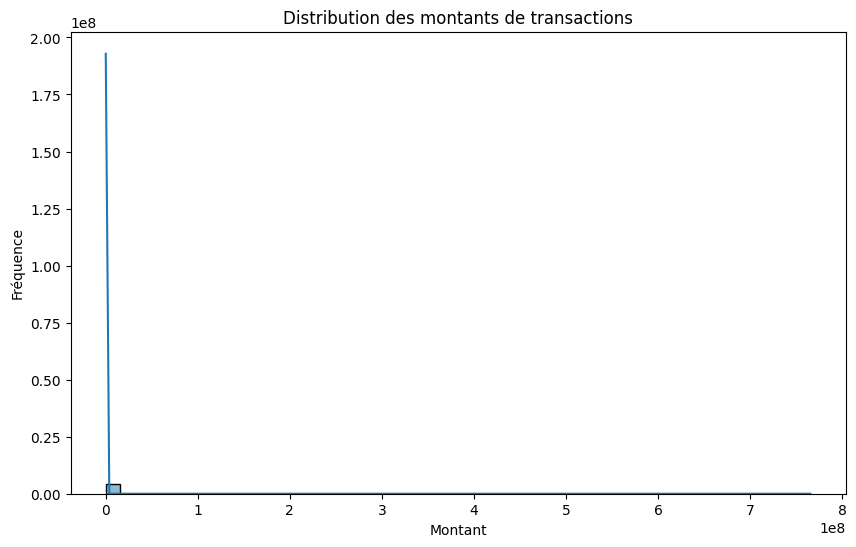

In [133]:
# Distribution des montants de transactions
plt.figure(figsize=(10, 6))
sns.histplot(data['amount'], bins=50, kde=True)
plt.title('Distribution des montants de transactions')
plt.xlabel('Montant')
plt.ylabel('Fréquence')
plt.show()


### Corrélation des variables :

Examiner la corrélation entre les variables pour comprendre les relations et identifier les caractéristiques importantes.

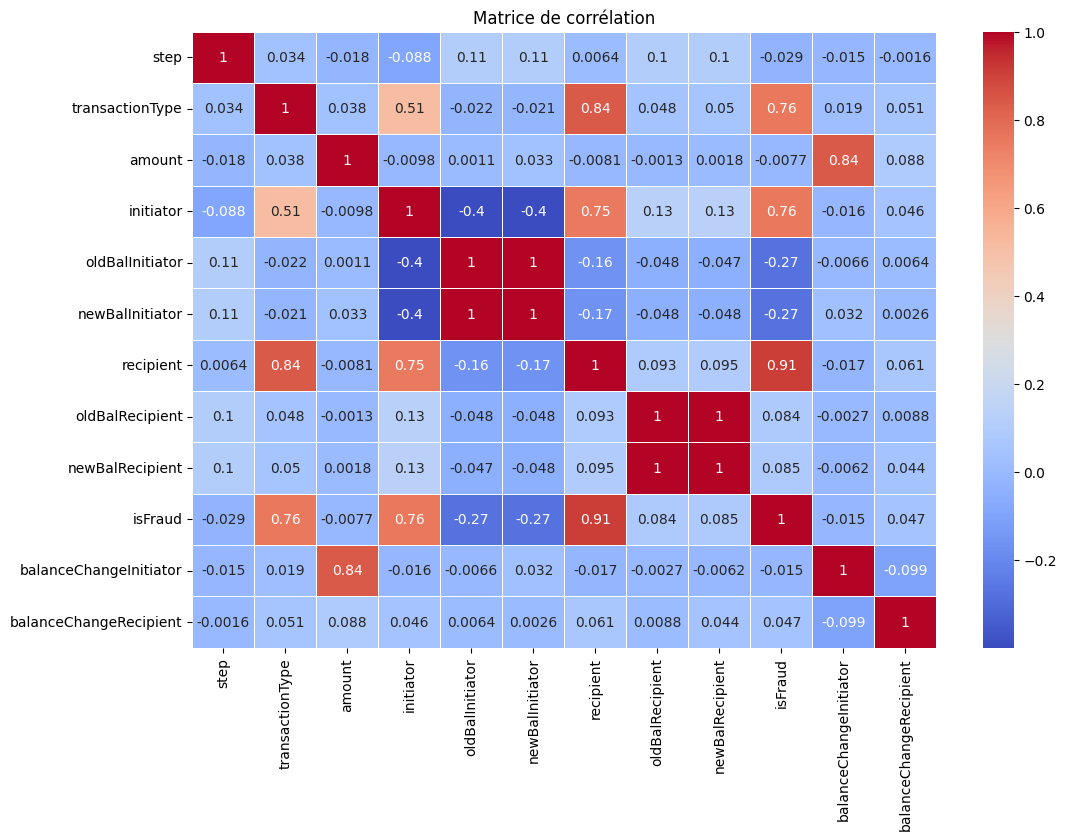

In [134]:
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()


### Analyse des valeurs aberrantes (outliers) :
Identifier et visualiser les valeurs aberrantes qui peuvent affecter l'analyse et le modèle.

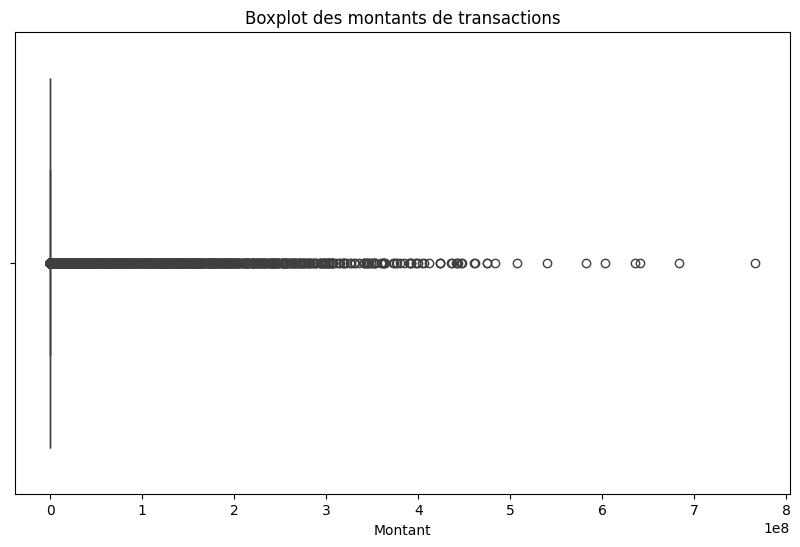

In [135]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['amount'])
plt.title('Boxplot des montants de transactions')
plt.xlabel('Montant')
plt.show()


### Analyse des transactions frauduleuses :
Comparer les transactions frauduleuses aux transactions légitimes.

isFraud
1    2233118
0    1992840
Name: count, dtype: int64


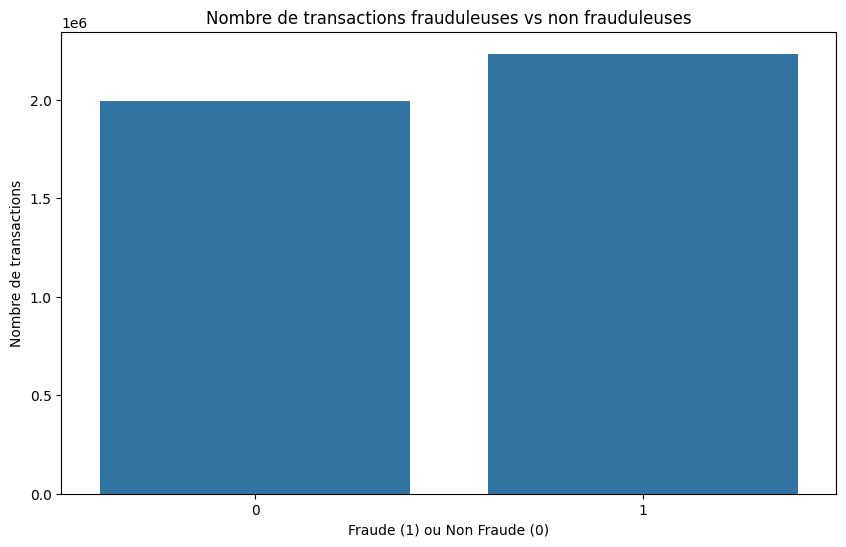

In [136]:
# Compter le nombre de transactions frauduleuses et légitimes
fraud_counts = data['isFraud'].value_counts()
print(fraud_counts)

# Visualiser les transactions frauduleuses vs non frauduleuses
plt.figure(figsize=(10, 6))
sns.countplot(x=data['isFraud'])
plt.title('Nombre de transactions frauduleuses vs non frauduleuses')
plt.xlabel('Fraude (1) ou Non Fraude (0)')
plt.ylabel('Nombre de transactions')
plt.show()


### Analyse par groupe :

Analyser les transactions par groupe (par exemple, par type de transaction).

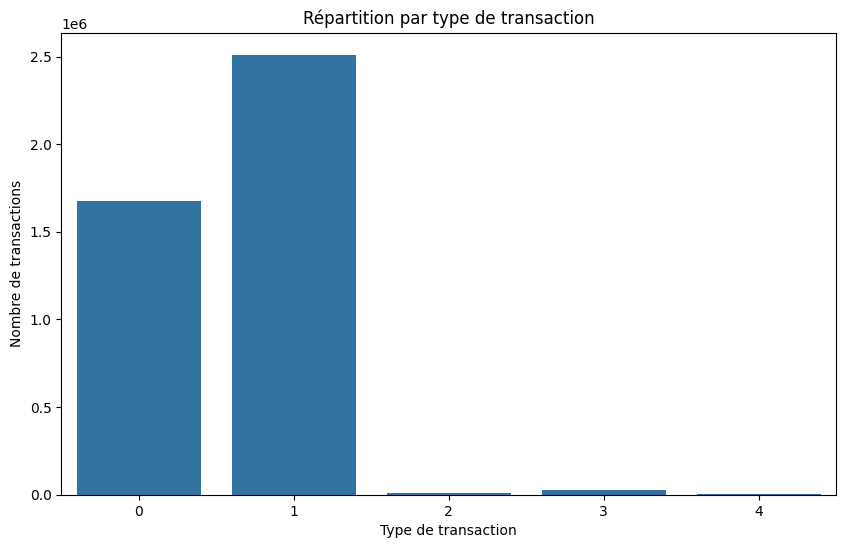

In [137]:
plt.figure(figsize=(10, 6))
sns.countplot(x=data['transactionType'])
plt.title('Répartition par type de transaction')
plt.xlabel('Type de transaction')
plt.ylabel('Nombre de transactions')
plt.show()


### Chronologie des transactions :

Visualiser le nombre de transactions au fil du temps.

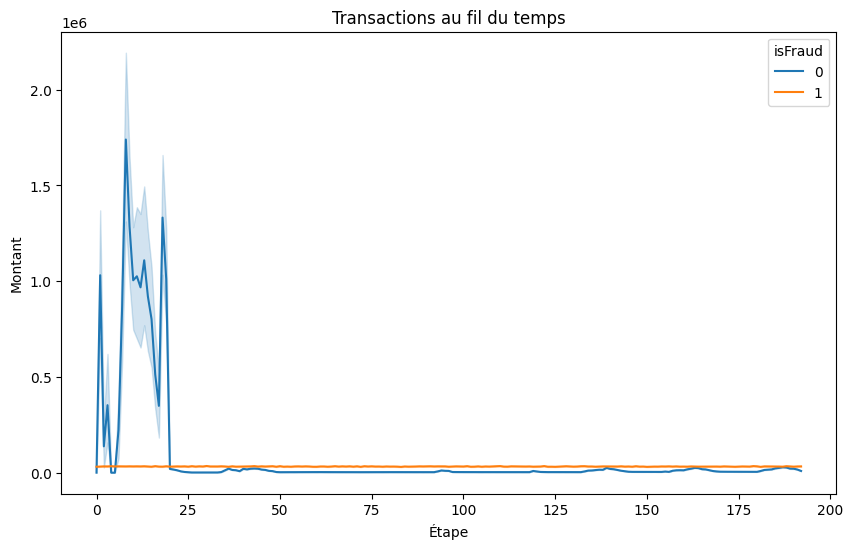

In [138]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='step', y='amount', hue='isFraud')
plt.title('Transactions au fil du temps')
plt.xlabel('Étape')
plt.ylabel('Montant')
plt.show()


## 6. Séparation des caractéristiques et de la cible

In [139]:
# Séparation des caractéristiques et de la cible
X = data.drop('isFraud', axis=1)
y = data['isFraud']

# Mise à l'échelle des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 7. Division des données en ensembles d'entraînement et de test

In [140]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## 8. Entraînement du modèle

In [141]:
# Initialiser le classificateur de Forêt Aléatoire
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 9. Prédiction sur les données de test

In [142]:
# Prédire les classes pour les données de test
y_pred = model.predict(X_test)

## 10. Évaluation du modèle

In [143]:
# Calculer le score de précision
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Afficher le rapport de classification
report = classification_report(y_test, y_pred)
print(report)

# Afficher la matrice de confusion
matrix = confusion_matrix(y_test, y_pred)
print(matrix)


Accuracy: 0.97106061896784
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    597541
           1       0.99      0.95      0.97    670247

    accuracy                           0.97   1267788
   macro avg       0.97      0.97      0.97   1267788
weighted avg       0.97      0.97      0.97   1267788

[[593176   4365]
 [ 32324 637923]]


In [188]:
X_test[0]

array([ 0.53612927, -1.16478667, -0.01937533,  0.3007479 , -0.34991994,
       -0.3498353 , -1.16739563, -0.22222088, -0.22471939, -0.00214779,
       -0.07647918])

In [189]:
# Définir et entraîner le Scaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[[
    'step', 'transactionType', 'amount', 'initiator', 'oldBalInitiator', 'newBalInitiator',	'recipient', 'oldBalRecipient', 'newBalRecipient', 'balanceChangeInitiator', 'balanceChangeRecipient'
]])

# Créer un DataFrame avec les caractéristiques mises à l'échelle
scaled_data = pd.DataFrame(scaled_features, columns=['step', 'transactionType', 'amount', 'initiator', 'oldBalInitiator', 'newBalInitiator', 'recipient', 'oldBalRecipient', 'newBalRecipient', 'balanceChangeInitiator', 'balanceChangeRecipient'])

# Exemple de nouvelles données pour la prédiction
# 0	PAYMENT	579.16	4018807983755588	29.32	29.32	30-0000345	0.00	0.00	0
new_data = {
    'step': [0],
    'transactionType': ['PAYMENT'],
    'amount': [579.16],
    'initiator': ['4018807983755588'],
    'oldBalInitiator': [5000.0],
    'newBalInitiator': [4000.0],
    'recipient': ['300000345'],
    'oldBalRecipient': [1000.0],
    'newBalRecipient': [2000.0],
    'balanceChangeInitiator': [4000.0],
    'balanceChangeRecipient': [2000.0]
}

# Convertir les nouvelles données en DataFrame
new_data_df = pd.DataFrame(new_data)

# Appliquer le mapping à la colonne transactionType dans les nouvelles données
new_data_df["transactionType"] = new_data_df["transactionType"].map(transaction_type_mapping)

# Vérifiez que les colonnes correspondent exactement
expected_columns = ['step', 'transactionType', 'amount', 'initiator', 'oldBalInitiator', 'newBalInitiator', 'recipient', 'oldBalRecipient', 'newBalRecipient', 'balanceChangeInitiator', 'balanceChangeRecipient']
new_data_df = new_data_df[expected_columns]

# # Mettre à l'échelle les nouvelles données en utilisant le scaler entraîné
new_data_scaled = scaler.transform(new_data_df)

# # Afficher les nouvelles données mises à l'échelle
print(new_data_scaled)

new_data_df


[[-1.76036658e+00 -1.16478667e+00 -1.93642868e-02  1.98094020e+16
  -3.49856573e-01 -3.49778991e-01  6.61915375e+08 -2.47801529e-01
  -2.50209785e-01 -2.91162490e-04 -7.04533270e-02]]


,step,transactionType,amount,initiator,oldBalInitiator,newBalInitiator,recipient,oldBalRecipient,newBalRecipient,balanceChangeInitiator,balanceChangeRecipient
0,0,0,579.16,4018807983755588,5000.0,4000.0,300000345,1000.0,2000.0,4000.0,2000.0


### Faire la prédiction avec le modèle entraîné

In [191]:
# Faire la prédiction
new_pred = model.predict(new_data_scaled)

prediction = model.predict([
    [ 0.53612927, -1.16478667, -0.01937533,  0.3007479 , -0.34991994,
       -0.3498353 , -1.16739563, -0.22222088, -0.22471939, -0.00214779,
       -0.07647918
    ]
])

# Afficher le résultat de la prédiction
print(f'La transaction est prédite comme {"frauduleuse" if new_pred[0] == 1 else "non frauduleuse"}.')

print(f'La transaction est prédite comme {"frauduleuse" if prediction[0] == 1 else "non frauduleuse"}.')

La transaction est prédite comme frauduleuse.
La transaction est prédite comme non frauduleuse.


## 11. Conclusion

### Conclusion
Le modèle de classification utilisant une Forêt Aléatoire pour la détection de fraudes a affiché des performances globales excellentes. Avec une précision de 97.1 %, le modèle a correctement classifié la grande majorité des transactions, qu'elles soient frauduleuses ou non frauduleuses. Les scores de précision et de rappel équilibrés pour les deux classes indiquent un bon compromis entre la capacité du modèle à détecter les fraudes (rappel) et à minimiser les fausses alertes (précision).

### Interprétation des Résultats
Précision Globale :

La précision globale de 97.1 % signifie que le modèle a correctement classé 97.1 % des transactions dans l'ensemble de test. Cela montre que le modèle est très performant pour distinguer les transactions frauduleuses des transactions légitimes.

Précision et Rappel :

Pour les transactions non frauduleuses (classe 0), le modèle a une précision de 0.95 et un rappel de 0.99. Cela indique que, bien que quelques transactions non frauduleuses soient faussement étiquetées comme frauduleuses, la majorité des transactions légitimes sont correctement identifiées.

Pour les transactions frauduleuses (classe 1), le modèle a une précision de 0.99 et un rappel de 0.95. Cela signifie que le modèle détecte la plupart des transactions frauduleuses (95 %), avec un très faible taux de fausses alertes.

Matrice de Confusion :

Les valeurs de la matrice de confusion montrent que le modèle a correctement classé 593,042 transactions non frauduleuses et 637,984 transactions frauduleuses.

Il y a 4,499 transactions non frauduleuses faussement classées comme frauduleuses (faux positifs) et 32,263 transactions frauduleuses non détectées (faux négatifs).

Implications pour l'Amélioration :

Bien que les résultats soient globalement très bons, il y a une marge d'amélioration, notamment en ce qui concerne la réduction des faux négatifs (transactions frauduleuses non détectées). Des ajustements des seuils de détection, l'intégration de nouvelles caractéristiques, ou l'utilisation de techniques de ré-échantillonnage pourraient améliorer les performances du modèle.

En conclusion, le modèle actuel est très efficace pour la détection des fraudes, mais il pourrait être encore optimisé pour améliorer le rappel des transactions frauduleuses et réduire les erreurs de classification. Ces améliorations contribueraient à renforcer la sécurité et la fiabilité du système de détection des fraudes.